INVESTMENTS - A modern approach to analyze investment opportunities

Readme: This tool analyzes stocks based on sentiments spotted in Twitter posts. Our program scrapes tweets including stock's ticker names of your interest and translates emojis and keywords included in the tweets into sentiments scores. The higher the senitment score, the better the popularity and senitmens regarding the stock, meaning that stocks with high sentiment scores could be a good investment opportunity. Since twitter is the social media platform where news about stocks appear first, we can play this advantage out and invest before others do.

As far as we have observed, most tweet sentiment analysis works focus on text analysis. For this reason, our primary goal in this work is to examine emojis and their implied sentiment scores.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import snscrape.modules.twitter as sntwitter
from emoji import UNICODE_EMOJI
import requests
import bs4
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import matplotlib.pyplot as plt

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


**Defining example ticker to work with**

As introduction to our program, we analyze the Apple Inc. stock (Ticker Name: AAPL) and guide you through our code and explain how it works and which functionalities it has.

In [2]:
ticker = "AAPL"

**Twitter scraping example**

With the following block of code, we scrape the last 500 tweets including the ticker symbols previously specified and gather them in the list “all_tweets”. Simultaniously we screen for emojis included in each tweet and gather them in the “all_emojis” list.



To only leave meaningful tweets, we filter by likeCount greater than 10. Then, emoji scores as weighted based on likeCount + replyCount. For example, one emoji in a tweet with 100 replies and likes is 5 times more valuable than emoji in a tweet with 20 likes and replies.

Source: https://medium.com/dataseries/how-to-scrape-millions-of-tweets-using-snscrape-195ee3594721


In [4]:
def twitter_scrape(ticker, max_tweets):
    tweet_dict = {}
    for i, tweet in enumerate(sntwitter.TwitterSearchScraper(ticker).get_items()):
        if i > max_tweets:
            break
        elif tweet.likeCount < 5:
            continue
        else:
            tweet_dict[tweet.content] = tweet.likeCount + tweet.replyCount

    full_dict = {}
    for tweet in tweet_dict:
        tweet_emojis = {}
        for element in tweet:
            if element in UNICODE_EMOJI['en']:
                tweet_emojis[element] = tweet_dict[tweet]
        full_dict[tweet] = tweet_emojis

    return full_dict

In [5]:
all_tweets = [i for i in twitter_scrape(ticker, 500)]
all_emojis = [values for keys, values in twitter_scrape(ticker, 500).items()]

**Scraping for emoji category data from the web:**

Next we needed to scrape for all emoji symbols and their sentiment scores. The website http://kt.ijs.si/data/Emoji_sentiment_ranking/ provides us with the necessary data. 

In [7]:
url = "http://kt.ijs.si/data/Emoji_sentiment_ranking/"
response = requests.get(url)
html_parsed = bs4.BeautifulSoup(response.text, 'html.parser')


**Classifying the main table into sub-tables with individual emojis (TRs):**

We transformed the table from the website including all emoji data into sub tables including data per specified emoji. 

In [8]:
tables = html_parsed.find_all("tr")

**Scraping emoji symbols:**

To scrape emoji symbols, particular symbols in the website code are used locate them.

In [9]:
emoji_list = []

for row in tables:
    string_row = str(row)
    emoji = string_row[(string_row.find("<tr><td>")+8):(string_row.find("<tr><td>")+9)]
    emoji_list.append(emoji)

**Scraping sentiment scores:**

Afterwards we need to scrape the sentiment score matching each emoji, which is done in the block of code below. The codes find the sentiment score in each table row (sub-table) by the location of a particular string. For negative scores, string is longer by one symbol because of the minus sign.

In [10]:
sentiment_scores = []

for row in tables:
    string_row = str(row)
    if string_row[string_row.find("sentiment score: ")+17] == "-":
        score = string_row[(string_row.find("sentiment score: ")+17):(string_row.find("sentiment score: ")+23)]
    else:
        score = string_row[(string_row.find("sentiment score: ")+17):(string_row.find("sentiment score: ")+22)]
    sentiment_scores.append(score)

**Creating a dictionary:**

Finally we gather the scraped data in a dictionary including emojis and associated sentiment scores. I.e. we make relationships between them that can be used later.

In [11]:
score_dict = {}
for i in range(1,752):
    score_dict[emoji_list[i]] = sentiment_scores[i]

**Calculating sentiment scores from actual tweets:**

As a final step in our analysis using emoji sentiment scores, the block of code below sums the sentiment scores for all tweets per ticker and outputs it’s total score per stock ticker symbol. Note, that negative sentiments have a negative sign meaning that the higher the sentiment score the more positively the tweets regarding a specific stock tend to be. 

In [13]:
def emoji_score(all_emojis : dict):
    total_score = 0
    for emoji in all_emojis:
        if emoji: # Checking if the emoji list is not empty
            for individual_emoji in emoji:
                if individual_emoji in score_dict.keys():
                    # Scaling the emoji weight by the number of likes and replies:
                    total_score = total_score + float(score_dict[individual_emoji]) * float(emoji[individual_emoji]) 
    total_score = total_score / len(all_emojis) # Dividing total score by the number of tweets that fulfill the criteria to allow for comparison between different tickers
    return round(total_score,2)

In [14]:
emoji_score_ticker = emoji_score(all_emojis)
emoji_score_ticker

3.57

**Starting with text analysis using NLTK:**

Source: https://realpython.com/python-nltk-sentiment-analysis/

NLTK is a helpful module which facilitates our sentiment analysis for the text in our scaped tweets.

**Importing stop-words, such as "and", "or" and "but" to filter them out:**

In a first step we shorten the text length of each tweet by simply filtering filling words out. 

In [15]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Creating tokenized lists of tweet words:**

Here we check each word in each tweet, remove the stopwords and only keep alphabet symbols.

In [16]:
tokenized_list = []
for x in all_tweets:
    split_tweet = x.split()
    for word in split_tweet:
        if word.isalpha():
            if word.lower() not in stopwords:
                tokenized_list.append(word.lower())


**Looking at the most frequent words:**

In [17]:
x = nltk.FreqDist(tokenized_list)
x.tabulate(10)

    may    call   today   apple    aapl    week account     put      de     cap 
     11       7       4       3       3       3       3       3       3       2 


**Looking at the most frequent three-word collocations:**

In [18]:
y = nltk.collocations.TrigramCollocationFinder.from_words(tokenized_list)
y.ngram_fd.most_common(5)

[(('may', 'call', 'may'), 6),
 (('call', 'may', 'call'), 4),
 (('may', 'put', 'may'), 3),
 (('call', 'may', 'put'), 2),
 (('put', 'may', 'call'), 2)]

**Performing sentiment analysis using VADER library:**

By using the “SentimentIntensityAnalyzer” module and defining thresholds in the sentiment scores we define “positive”, “negative” and “neutral” tweets based on the text sentiment analysis.

In [19]:
sent = SentimentIntensityAnalyzer()

**Counting the number of positive, negative and neutral tweets:**

In [20]:
def text_score(all_tweets):
    positive = 0
    negative = 0
    neutral = 0
    for x in all_tweets:
        tweet_score = sent.polarity_scores(x)
        if tweet_score["compound"] >= 0.3:
            positive += 1
        elif tweet_score["compound"] > -0.3:
            neutral += 1
        else:
            negative += 1
    return [positive, neutral, negative]

**Providing a summary of the sentiment, that is, emoji score + number of positive/negative/neutral tweets:**

This is an example score for Apple.

In [21]:
emoji_score2 = emoji_score(all_emojis)
text_score2 = text_score(all_tweets)

print("Emoji Score:", emoji_score2, ". Positive, Neutral and Negative Tweets: ", text_score2)

Emoji Score: 3.57 . Positive, Neutral and Negative Tweets:  [10, 20, 3]


**Providing a summary of these scores for selected tickers:**

Now, it’s your turn! Use as many ticker symbols as you want to analyze by typing them into the provided input box. After you typed the last ticker symbol you want to add simply type “Stop” in the input box and the loop will break. Thereafter jump to the last line and see the results provided!
The scores will be calculated based on last 500 tweets for each inputted ticker (if they satisfy like count criteria).

In [22]:
selected_ticker_scores = pd.DataFrame()
input_ticker = ""
input_ticker_list = []

while input_ticker != "Stop":  
    input_ticker = str(input("Please enter some tickers or type 'Stop': "))
    if input_ticker != "Stop":
        input_ticker_list.append(input_ticker)

for ticker in input_ticker_list:
    try:
        tweets = [i for i in twitter_scrape(ticker, 500)]
        emojis = [values for keys, values in twitter_scrape(ticker, 500).items()]
    except:
        continue
    selected_ticker_scores.loc[ticker, "Emoji Score"] = emoji_score(emojis)
    selected_ticker_scores.loc[ticker, "Positive Tweets"] = text_score(tweets)[0]
    selected_ticker_scores.loc[ticker, "Neutral Tweets"] = text_score(tweets)[1]
    selected_ticker_scores.loc[ticker, "Negative Tweets"] = text_score(tweets)[2]

**Sorting by the highest Emoji Scores, as an example:**

In [23]:
selected_ticker_scores.sort_values(by=["Emoji Score"], ascending=False)

,Emoji Score,Positive Tweets,Neutral Tweets,Negative Tweets
AMZN,3.08,11.0,17.0,1.0
TSLA,2.34,8.0,15.0,5.0


**Plotting:**

Defining a function for plotting selected column:

In [24]:
def plot_function(column):
    y = np.array(selected_ticker_scores[column])
    x = selected_ticker_scores.index

    chart_title = column + " For Selected companies"

    plt.style.use('ggplot')
    plt.bar(x, y, color="green")
    plt.xlabel("Companies")
    plt.ylabel(column)
    plt.title(chart_title)
    plt.show()

    plt.pie(y, labels=x)
    plt.title(chart_title)
    plt.show()

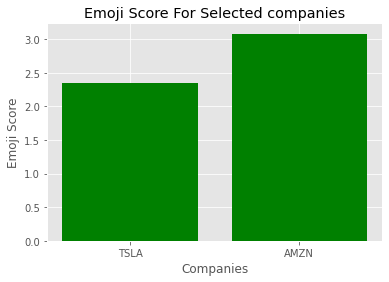

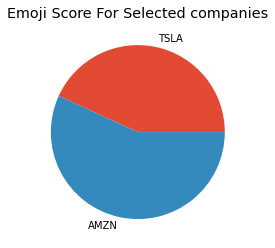

In [25]:
plot_function("Emoji Score")

**Extension:**

The following code expands the analysis for S&P 500 companies and sorts them based on their emoji scores.

In [26]:
wikipedia=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = wikipedia[0]
tickers = first_table["Symbol"]
sp_tickers = [i for i in tickers]

In [27]:
sp_scores = pd.DataFrame()

for ticker in sp_tickers[0:5]: # Looping just through the first 5 tickers to save time
    tweets = [i for i in twitter_scrape(ticker, 500)]
    emojis = [values for keys, values in twitter_scrape(ticker, 500).items()]
    sp_scores.loc[ticker, "Emoji Score"] = emoji_score(emojis)
    sp_scores.loc[ticker, "Positive Tweets"] = text_score(tweets)[0]
    sp_scores.loc[ticker, "Neutral Tweets"] = text_score(tweets)[1]
    sp_scores.loc[ticker, "Negative Tweets"] = text_score(tweets)[2]

sp_scores.sort_values(by=["Emoji Score"], ascending=False)

,Emoji Score,Positive Tweets,Neutral Tweets,Negative Tweets
ABBV,7.51,5.0,32.0,1.0
AOS,1.33,0.0,12.0,3.0
ABMD,0.24,5.0,19.0,1.0
MMM,0.00,2.0,1.0,0.0
ABT,0.00,4.0,5.0,4.0


Using the logic provided, the code can be expanded for whatever selection of companies the user wants to.